# Проект по разработке стратегии взаимодействия с клиентами

Для фитнес-клубов «Культурист-датасаентист» разрабатывается стратегия взаимодействия с клиентами на основе аналитических данных. Есть база электронных анкет клиентов, по которой нужно понять специфику отрасли, и определить индикаторы оттока клиентов.

Задачи:

- спрогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
        1) выделить целевые группы клиентов;
        2) предложить меры по снижению оттока;
        3) определить другие особенности взаимодействия с клиентами.

## Вывод данных

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('/datasets/gym_churn.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

Имеем следующие данные:
 - Данные клиента за предыдущий до проверки факта оттока месяц:
        - 'gender' — пол;
        - 'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
        - 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
        - Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
        - 'Phone' — наличие контактного телефона;
        - 'Age' — возраст;
        - 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).
        
        И в таблице есть информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
        - 'Contract_period' — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
        - 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
        - 'Group_visits' — факт посещения групповых занятий;
        - 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
        - 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
        - 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
        - 'Churn' — факт оттока в текущем месяце.
        
        Количество данных 4000 строк. Пропусков нет

In [4]:
data.columns = data.columns.str.lower() # поменяем в названиях колонок регистр на нижний
data.head(5)

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [5]:
data.duplicated().sum() # дубликатов нет

0

## Исследовательский анализ данных (EDA)

In [6]:
data.describe().T # посмотрим на датасет с помощью describe

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


Выводы:
- по gender делится приблизительно пополам - среднее значение 0,51
- по локации 84 % клиента живут или работают в районе фитнесса
- 49 % являются сотрудниками компаний, которые получают скидки на абонемент
- 30 % пришли по промокоду от друга
- Contract_period - средняя длительность текущего абонемента 4,68 месяца. 25% клиентов имеют абонемент на 6 месяцев и более. А 75 % клиентов имеют абонемент всего на 1 месяц.
- 41 % клиентов посещают групповые занятия
- средний возраст клиентов 29 лет. Максимум - 41 год. 50 % клиентов в возрасте от 27 до 31 года.
- в среднем на оплату сопутствующих услуг тратится суммарно 146,9 ед. денег. Половина клиентов платит 136.22.
- Month_to_end_contract - в среднем до окончания контракта остается 4,32 месяца, то только у 25 % клиентов более 6 месяцев и до 12. А более половины клиентов имеют 1 месяц до окончания контракта.
- Lifetime - в среднем 3,72 месяца прошло с момента первого обращения в фитнес-центр 
- Avg_class_frequency_total - средняя частота посещений в неделю за все время с начала действия абонемента - в среднем в неделю клиенты ходят почти 2 раза (1,87), а 25 % клиентов 2,5 раза в неделю.
- Avg_class_frequency_current_month - за последний месяц средний приход в неделю составляет 1,76 раза. А 25 % клиентов стабильно ходят 2,5 раза в неделю за последний месяц.
- По оттоку в текущем месяце 'Churn': 1 - кто ушли, 0 - кто остались. 26,5 % клиентов ушли в текущем месяце.

Явных выбросов нет.

In [7]:
data.groupby('churn').mean() # средние значения признаков в двух группах 1 - ушли, 0 остались

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


In [8]:
data.groupby('churn').mean().T # перевернем таблицу

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


Средние значения признаков тех кто ушли ниже, чем у тех кто остался (кроме gender - поровну (значит пол не влияет на уход).
- Близость локации - near_location - Значение высоки в двух группах, но у тех кто ушел доля ниже (76,8%) Признак влияет на отток клиентов 
- partner - признак влияет на отток клиентов. Среди "не партнеров" отток выше.
- по промокоду такжу ушло меньше клиентов.
- оставления телефона никак не влияет на отток.
- contract_period - длительность контракта имеет сильное влияние. Из тех кто ушел в среднем абонемент имели менее 2 месяцев. 
- group_visits. Занимающий в группах клиент менее подвержен уходу из фитнеса.
- Средний возраст ушедших 27 лет, оставшихся - почти 30 лет.
- оставшиеся потратили больше на доп услуги.
- month_to_end_contract - имеет сильное положительное влияние. Смысл ходить если и так мало осталось. Если абонемент действует еще полгода, можно и вернуться.
- lifetime - сильное положительное влияние. Чем дольше ходишь, тем сильнее привыкаешь.
- avg_class_frequency_total	- влияние частоты посещений. у тех кто остался она выше. Регулярность имеет положительное влияние.
- avg_class_frequency_current_month - такая же ситуация за последний месяц. Главное регулярно, 2 раза в неделю.

### Визуализация распределения признаков по Ушел-Остался

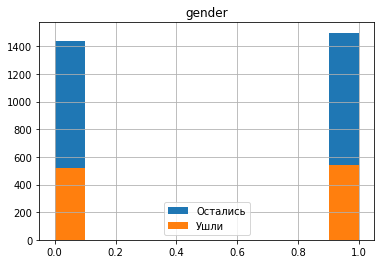

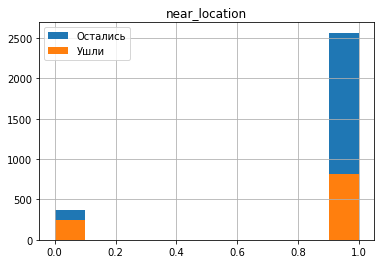

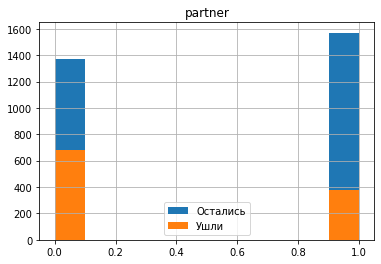

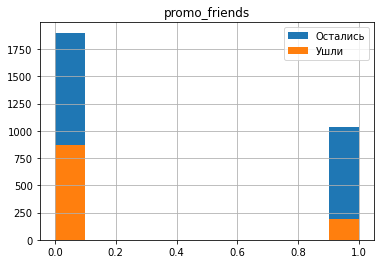

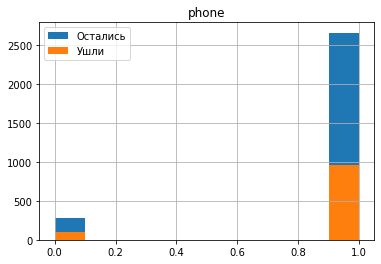

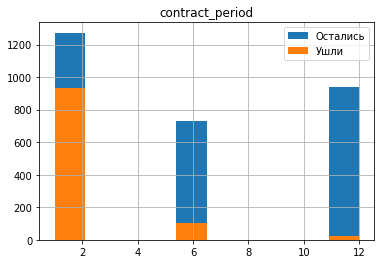

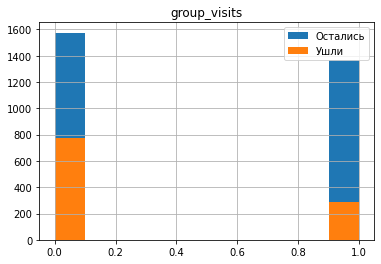

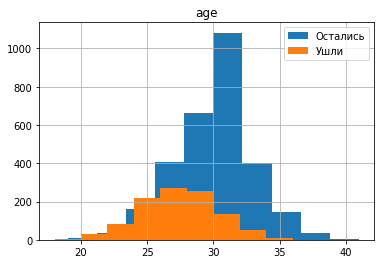

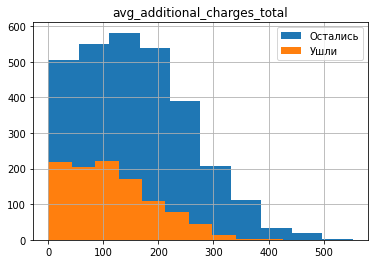

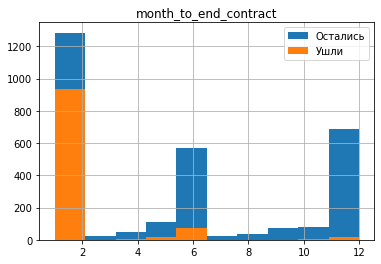

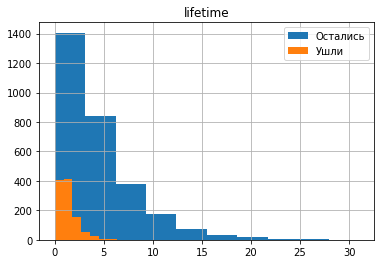

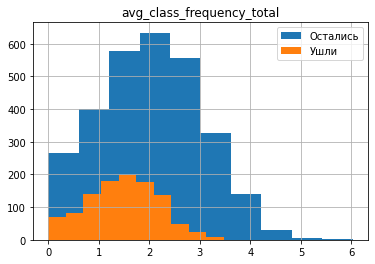

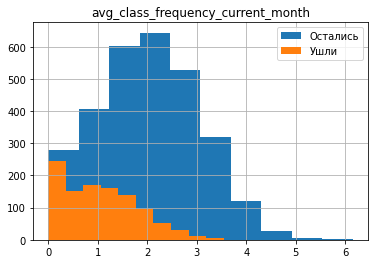

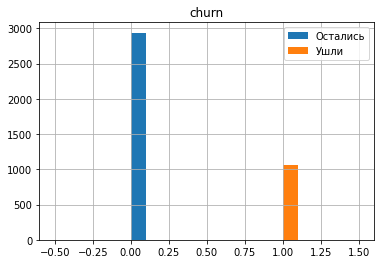

In [9]:
for col in data.columns:
    data.groupby('churn')[col].hist()
    plt.title(col)
    plt.legend(['Остались', 'Ушли'])
    plt.show()

Про графики распределения:
* беглый взгляд дает, что на отток клиентов влияют такие признаки: локация, партнерство, промокод, длительность абонемента, групповые занятия

### Матрица корреляций, отображение

In [10]:
cm = data.corr() #вычисляем матрицу корреляций
cm

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
gender,1.000000,0.006699,-0.010463,-0.005033,-0.008542,0.000502,0.017879,0.013807,-0.009334,-0.001281,0.013579,0.014620,0.009156,0.000708
near_location,0.006699,1.000000,-0.005119,0.210964,-0.015763,0.150233,0.154728,0.058358,0.040761,0.143961,0.070921,0.043127,0.062664,-0.128098
partner,-0.010463,-0.005119,1.000000,0.451960,0.009970,0.306166,0.022710,0.047480,0.022941,0.294632,0.061229,0.024938,0.045561,-0.157986
promo_friends,-0.005033,0.210964,0.451960,1.000000,0.001982,0.244552,0.120170,0.050113,0.036898,0.239553,0.072721,0.028063,0.053768,-0.162233
phone,-0.008542,-0.015763,0.009970,0.001982,1.000000,-0.006893,-0.010099,-0.011403,0.009279,-0.011196,-0.018801,0.008340,0.013375,-0.001177
contract_period,0.000502,0.150233,0.306166,0.244552,-0.006893,1.000000,0.169991,0.138249,0.111445,0.973064,0.170725,0.096211,0.159407,-0.389984
group_visits,0.017879,0.154728,0.022710,0.120170,-0.010099,0.169991,1.000000,0.080934,0.032079,0.163703,0.075853,0.056695,0.075923,-0.175325
age,0.013807,0.058358,0.047480,0.050113,-0.011403,0.138249,0.080934,1.000000,0.080240,0.134511,0.164693,0.119953,0.183095,-0.404735
avg_additional_charges_total,-0.009334,0.040761,0.022941,0.036898,0.009279,0.111445,0.032079,0.080240,1.000000,0.113958,0.079028,0.044426,0.079570,-0.198697
month_to_end_contract,-0.001281,0.143961,0.294632,0.239553,-0.011196,0.973064,0.163703,0.134511,0.113958,1.000000,0.161078,0.085387,0.147605,-0.381393


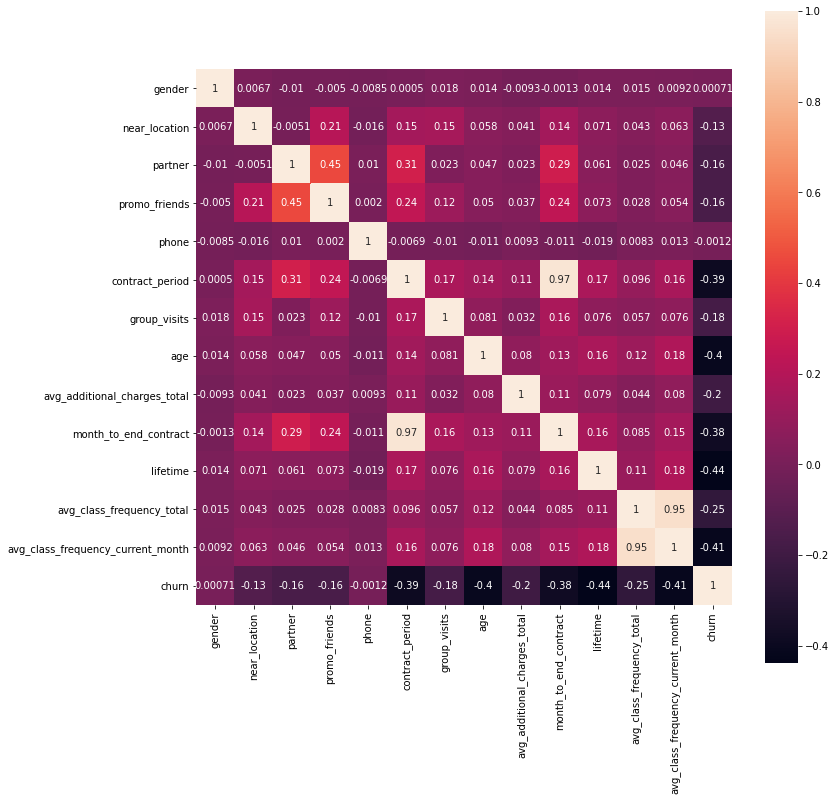

In [11]:
fig, ax = plt.subplots(figsize=(12, 12)) # тепловая карту для матрицы корреляций
sns.heatmap(cm, annot=True, square=True) 
plt.show() 

- Имеется две пары мультиколлинеарных признаков, в каждой паре можно в ручную убрать один признак из модели:
    - 'contract period' и 'month to end contract' - коэффициент корреляции 0.97. 
    - 'avg_class_frequency_current_month' с 'avg_class_frequency_total' - коэффициент корреляции 0.95.
- Степень зависимости оттока от других признаков разная:
    - пол и наличие телефона не влияют никак
    - локация, партнерство, promo-код, групповые занятия, траты на доп.услуги, общая частота посещений имеют слабое влияние на отток клиентов - до 0,25.
    - длительность контракта, возраст (на графике распределения он не очевиден), длительность знакомства с клубом, и частота посещений за последний месяц имеют среднюю зависимость 
- Признаки имеют обратную зависимость, т.е. чем меньше значение признака, тем больше отток клиентов        

## Модель прогнозирования оттока клиентов

Модель бинарной классификации клиентов

In [12]:
X = data.drop('churn', axis=1) #признаки
y = data['churn'] # целевая переменная

In [13]:
#обучающаяся (train) и валидационная выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) 
#random_state отвечает за «случайность» 

In [14]:
model_lr = LogisticRegression() 
model_lr.fit(X_train, y_train) # обучение модели логистической регрессии
predictions_lr = model_lr.predict(X_test)
probabilities_lr = model_lr.predict_proba(X_test)[:,1] #делаем прогнозы воспользовавшись обученной моделью

In [15]:
model_rf = RandomForestClassifier(random_state=0)
model_rf.fit(X_train, y_train) # обучение модели алгоритмом случайный лес
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
predictions_rf = model_rf.predict(X_test) #сделаем прогноз обученной модели случайнный лес
probabilities_rf = model_rf.predict_proba(X_test)[:, 1] 

Метрики accuracy, precision и recall на валидационной выборке

In [16]:
print('Метрики для модели логистической регрессии:')
acc_lr = accuracy_score(y_test, predictions_lr)  # доля правильных ответов
precision_lr = precision_score (y_test, predictions_lr) #точность - долю правильных ответов только среди целевого класса
recall_lr = recall_score (y_test, predictions_lr) #полнота - сколько реальных объектов "1" обнаружено

print('Accuracy: {:.2f}'.format(acc_lr))
print('Precision: {:.2f}'.format(precision_lr))
print('Recall: {:.2f}'.format(recall_lr))

print('Метрики для модели случайного леса:')
acc_rf = accuracy_score(y_test, predictions_rf)  # доля правильных ответов
precision_rf = precision_score (y_test, predictions_rf) #точность - долю правильных ответов только среди целевого класса
recall_rf = recall_score (y_test, predictions_rf) #полнота - сколько реальных объектов "1" обнаружено

print('Accuracy: {:.2f}'.format(acc_rf))
print('Precision: {:.2f}'.format(precision_rf))
print('Recall: {:.2f}'.format(recall_rf))

Метрики для модели логистической регрессии:
Accuracy: 0.91
Precision: 0.82
Recall: 0.80
Метрики для модели случайного леса:
Accuracy: 0.92
Precision: 0.84
Recall: 0.82


- Правильное прогнозирование у двух моделей - более 87 % ответов, но Accuracy работает не всегда, а только при условии баланса классов — когда объектов каждого класса примерно поровну, 50% на 50%. У нас класс '1' - 26,5%.
- Доля правильных прогнозов, точность и полнота выше у модели случайный лес. Метрика precision здесь более важна.
- Модель случайный лес лучше

## Кластеризацию клиентов


In [17]:
scaler = StandardScaler() # создаём объект класса scaler (нормализатор)
x_sc = scaler.fit_transform(X) # обучаем нормализатор

In [18]:
linked = linkage(x_sc, method = 'ward') # строим матрицу расстояний
linked 

array([[9.70000000e+01, 3.22200000e+03, 1.00990653e-01, 2.00000000e+00],
       [2.61000000e+02, 3.17900000e+03, 1.22634574e-01, 2.00000000e+00],
       [8.90000000e+02, 1.75000000e+03, 1.28123291e-01, 2.00000000e+00],
       ...,
       [7.98700000e+03, 7.99500000e+03, 8.38725499e+01, 2.65600000e+03],
       [7.98800000e+03, 7.99600000e+03, 8.89563592e+01, 3.03400000e+03],
       [7.99200000e+03, 7.99700000e+03, 1.04627601e+02, 4.00000000e+03]])

### Дендрограмма

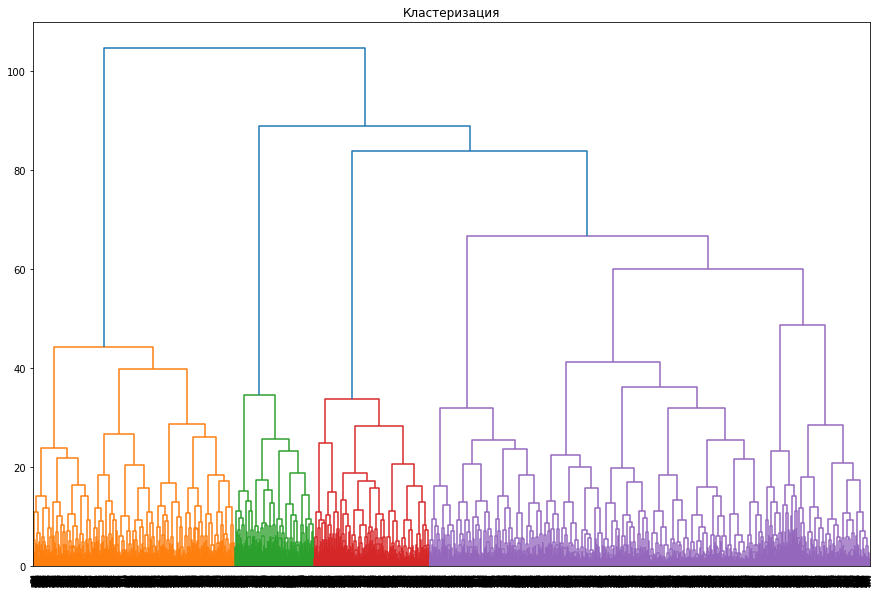

In [19]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Кластеризация')
plt.show()

Можно выделить как минимум 4 кластера клиентов, возможно даже 5 или 6. 

### Кластеризации по алгоритму K-Means

In [20]:
km = KMeans(n_clusters=5, random_state=0) # число кластеров приняли n=5
labels = km.fit_predict(x_sc) 
data['cluster'] = labels

In [21]:
# выводим статистику по средним значениям наших признаков по кластеру
data_mean = data.groupby('cluster').mean().T
data_mean

cluster,0,1,2,3,4
gender,0.502970,0.522078,0.495050,0.485737,0.559666
near_location,0.959406,0.862338,0.000000,1.000000,0.976134
partner,0.783168,0.470130,0.463366,0.350238,0.356802
promo_friends,0.574257,0.306494,0.079208,0.240095,0.230310
phone,1.000000,0.000000,1.000000,1.000000,0.998807
contract_period,10.889109,4.787013,2.352475,1.948494,2.669451
group_visits,0.542574,0.425974,0.215842,0.341521,0.473747
age,29.982178,29.301299,28.477228,28.167987,30.125298
avg_additional_charges_total,160.761016,143.957664,135.457501,131.622204,161.657905
month_to_end_contract,9.954455,4.475325,2.198020,1.856577,2.459427


In [22]:
data.groupby(['cluster'])['gender'].count() #посмотрим на количество клиентов в каждом кластере
# размеры кластера достаточные для качественных выводов 

cluster
0    1010
1     385
2     505
3    1262
4     838
Name: gender, dtype: int64

###### Сразу отметим, 
- самые склонные к оттоку 2 и 3 кластер (0.44 и 0.51 соответственно) = 505+1262 = 1767 клиентов
- самые надежные - это кластеры 0 и 4 - 1010 + 838 = 1848 клиентов 
- кластер 3 самый многочисленный и самый склонный к оттоку и самый молодой, кстати)

Кластер 0 - (Стабильные)
- количество клиентов 1010
- отток самый низкий - 2,77%
- локация близкая - почти единица - 0,95
- партнеры и промокоды самые высокие значения из всех кластеров
- ходят на групповые занятия (0,54)
- заключен контаркт на 12 месяцев
- и заниматься еще 10 месяцев)

Кластер 1 - (Не оставляющие телефоны)
- количество клиентов 385
- доля оттока - 26%
- локация близкая - 0,86
- партнеры меньше почти в два раза чем в Кластере 0
- заключен контаркт на 4,7 месяцев (т.е. 1 или 6 месяцев)
- и заниматся еще в среднем 4,5 месяца

Кластер 2 - (Не с нашего двора)
- количество 505
- доля оттока - 44%
- локация - значение 0 - близко не живут
- партнеры меньше почти в два раза чем в Кластере 0
- заключен контаркт на 2,35 месяцев (т.е. 1 или 6 месяцев)
- заниматся еще в среднем 2,19 месяца

Кластер 3 - (Молодые и горячие)
- количество 1262 (самый многочисленный)
- доля оттока - 51% (самый высокий показатель)
- локация = 1 - все близко 
- партнеры меньше в два раза чем в Кластере 0
- заключен контаркт на 1,94 месяцев (т.е. 1 или 6 месяцев, преобладают с 1 месяцем)
- заниматся еще в среднем 1,85 месяца
- самая молодая группа (28,16 лет)
- ходят реже всех групп раз в неделю

Кластер 4 - (Близкие и частые)
- количество 838
- доля оттока маленькая - 6,8% 
- локация = 1 - все близко 
- партнеры меньше в два раза чем в Кластере 0
- заключен контаркт на 2,66 месяцев (т.е. 1 или 6 месяцев)
- заниматся еще в среднем 2,45 месяца
- ходят чаще всех групп - 2,85 раза в неделю

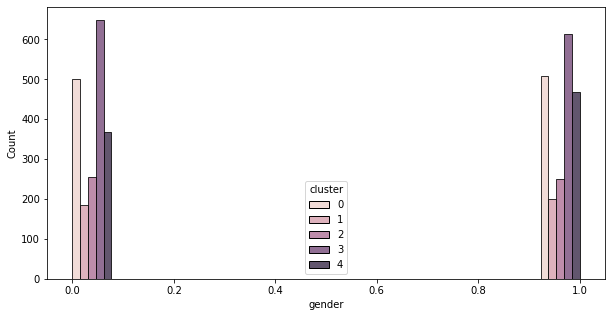

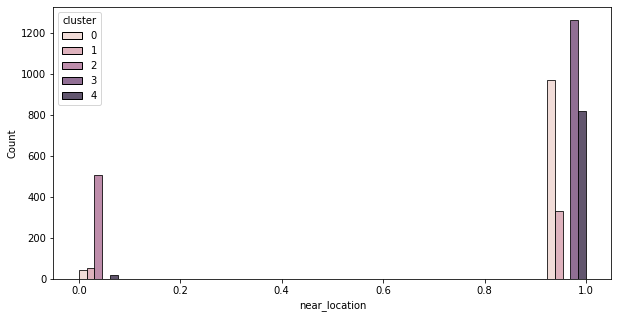

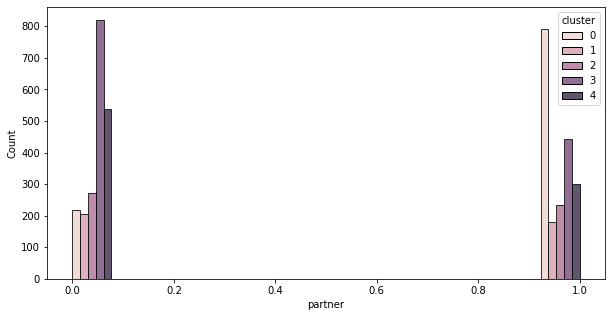

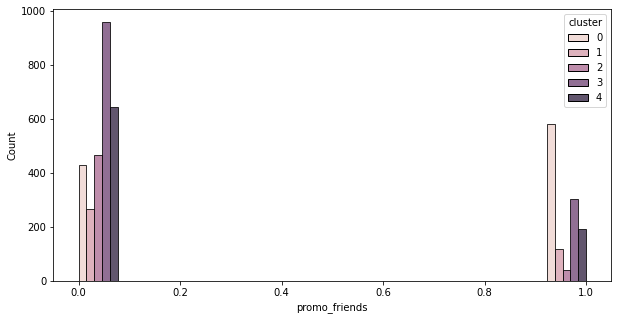

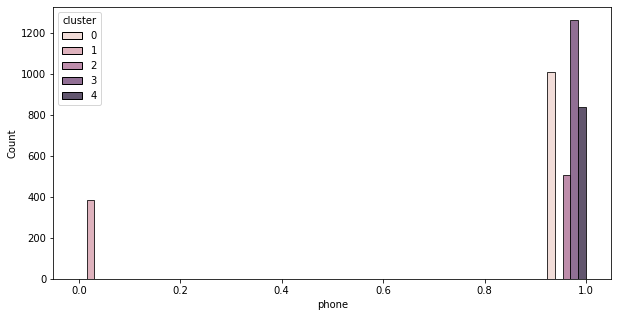

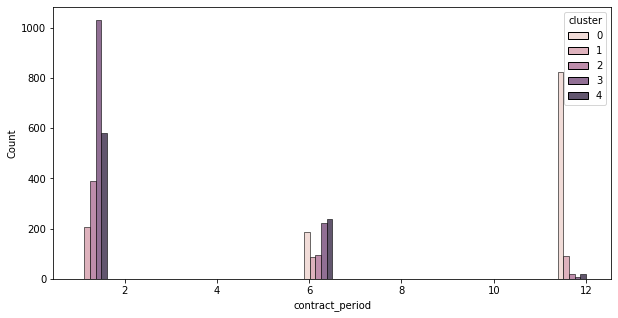

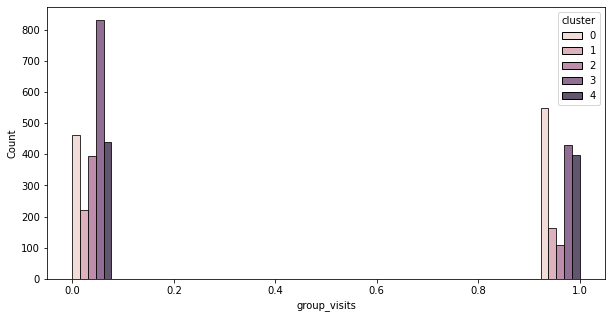

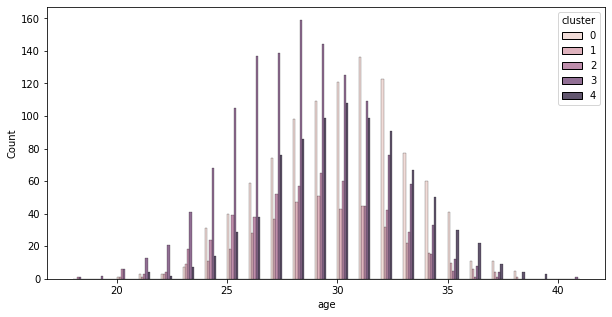

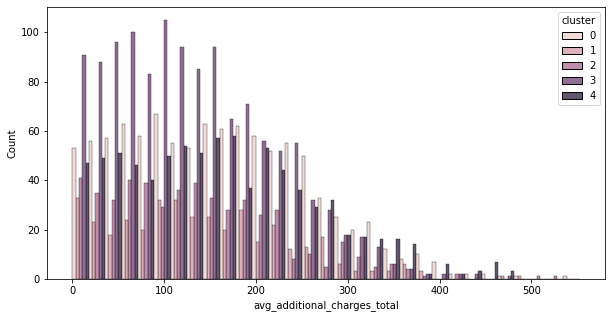

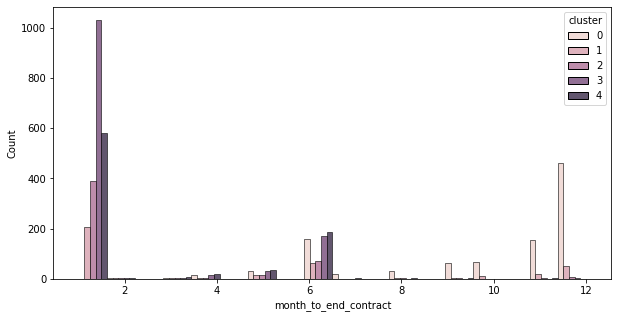

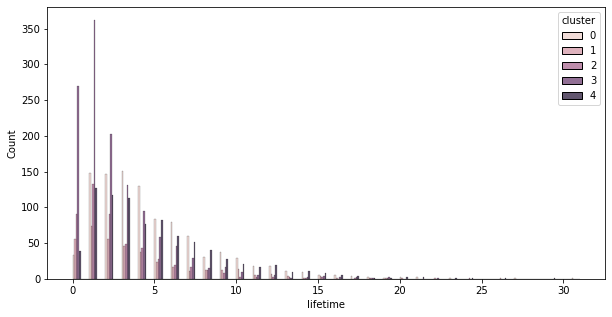

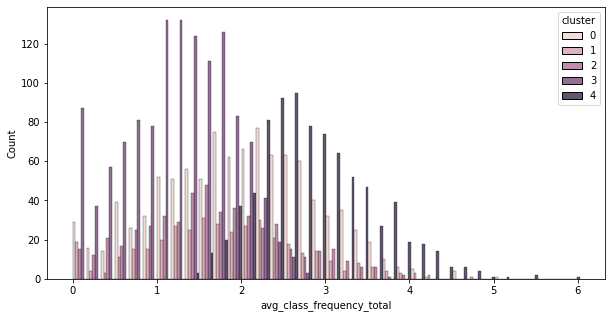

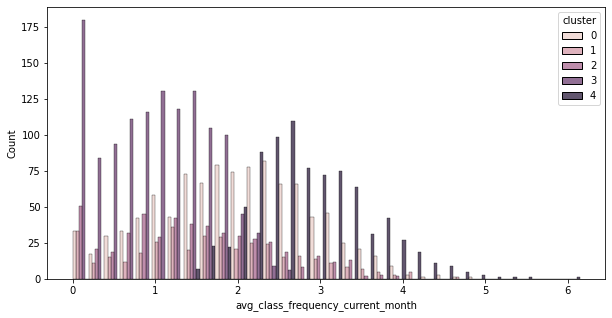

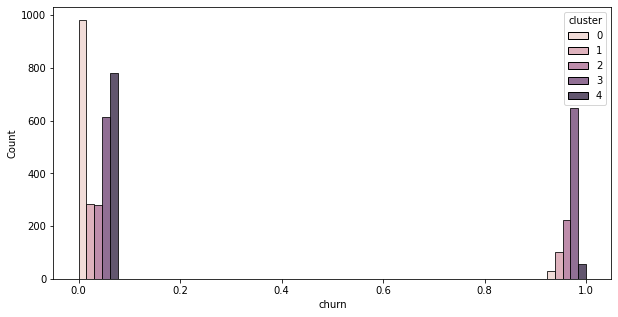

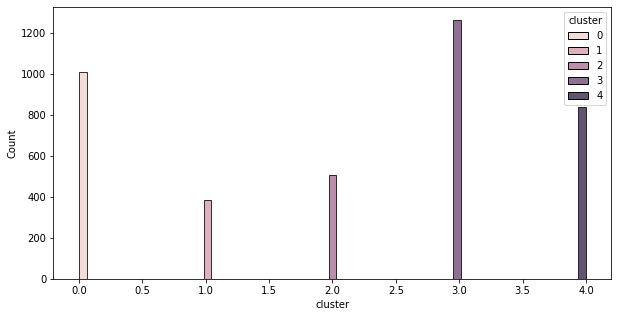

In [23]:
for col in data.columns:
    plt.figure(figsize=(10, 5))
    sns.histplot(data=data, x=col, hue='cluster', multiple='dodge', color='result')
    plt.show()    

Выводы по графикам: (напомним, надежные кластеры - 0 и 4) и (2 и 3 кластеры склонны к оттоку)
- по полу приблизительно одинаковое распределение
- по локации выделяется кластер 2, где все живут и работают не рядом.
- партнерские программы хорошо себя показали, почти 50 % клиентов ими пользуются, активно в кластере 0.
- промо коды менее популярны чем приход клиента как партнер, но промокоды также популярны в кластере 0. 
- по длительности абонемента выделяется кластер 0 с абонементом на год. И кластер 3 с абонементом на 1 мес. 6 мес. абонементы приблизительно ровное количество в каждом кластере
- групповые программы популярны в 0, 3 и 4 кластерах
- интересно распределение по возрасту. Пик кластера 0 находится на 31 год, а пик кластера 3 смещен влево и составляет 28 лет
- примечательно, что 0 и 4 кластер стабильно тратятся на допуслуги.
- по количеству месяцев до конца выделяем кластер 0 и 4, им осталось 6 и 12 месяцев.
- в среднем с фитнесом знакомы 2-3 месяца. И кластер 3 - пиковое значение 1 месяц
- по частоте посещения кластер 0 и 4 ходит 2-3 раза в неделю. Кластер 3 пиковое количество 1-2 раза в неделю. 

## Выводы и рекомендации по работе с клиентами

Вывод: 
- надежный и желанный клиент фитнесс-центра - это рядом живущий или работающий человек тридцатилетнего возраста, любого пола, привлеченный по партнерской программе и (или) по промокоду от друга, любит групповые занятий, посещает клуб 2-3 раза в неделю, и с абонементом на 1 год. 

Рекомендации: 
- продолжать работать, и использовать те активности что уже имеются
- рассмотреть возможность расширить виды партнерских программы и промокодов
- рассмотреть возможность увеличить виды групповых занятий, это заинтересует новые группы клиентов
- делать акцент на развитие уютной клубной атмосферы, чтобы повысить среднюю частоту посещения клуба
- рассмотреть возможность абонемента на 3 месяца, в дополнение к имеющимся.
- делать привлекающие активности (рассылки, смс, промокоды для бывших клиентов) для ушедших клиентов, т.к. самые молодые (28 лет и младше) являются кандидатами на уход, но возможно через пару лет заходят вернутся в знакомый им клуб, и станут самыми стабильными клиентами. 